In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_6k_collection)

In [2]:
tfs = load_annotated_6k_collection()
m1h = load_m1h_activation_data()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
m1h['iso_acc'] = m1h['clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

reading from cache


In [3]:
from data_loading import load_tf_families
df = pd.DataFrame([(tf_name, tf.isoforms[0].name, alt_iso.name) for tf_name, tf in tfs.items() for alt_iso in tf.isoforms[1:]],
                    columns=['gene', 'ref_iso', 'alt_iso'])
tf_fam = load_tf_families()
df['DBD'] = df['gene'].map(tf_fam)
df['m1h_ref'] = df['ref_iso'].map(m1h.set_index('iso_acc')['mean'])
df['m1h_alt'] = df['alt_iso'].map(m1h.set_index('iso_acc')['mean'])

In [4]:
m1h['DBD'] = m1h['gene'].map(tf_fam)
df['n_aa_diff'] = df.apply(lambda x: len(tfs[x['gene']][x['ref_iso']].aa_seq) - len(tfs[x['gene']][x['alt_iso']].aa_seq), axis=1)
print((df['n_aa_diff'] < 1).sum(), 'n_aa_diff < 1')
# HACK
df['n_aa_diff'] = df['n_aa_diff'].abs()
df['pct_aa_diff'] = (df.apply(lambda x: (len(tfs[x['gene']][x['ref_iso']].aa_seq) - len(tfs[x['gene']][x['alt_iso']].aa_seq)) / len(tfs[x['gene']][x['ref_iso']].aa_seq), axis=1) * 100).abs()

226 n_aa_diff < 1


In [6]:
dbd_to_plot = df['DBD'].value_counts().index[:9]

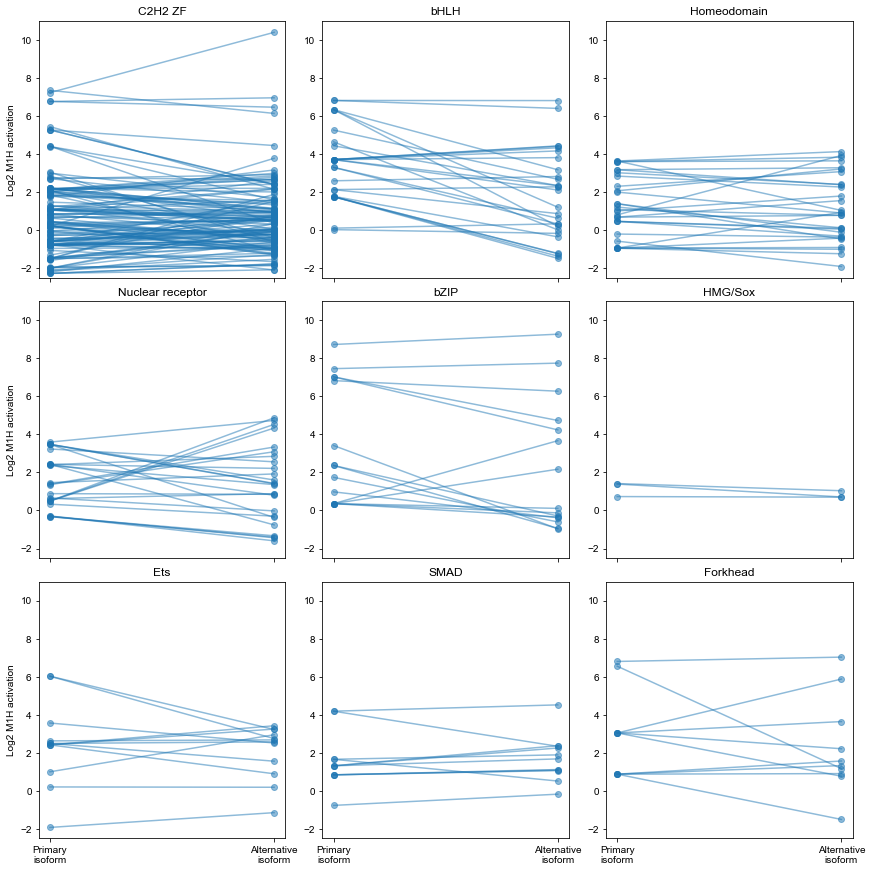

In [5]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(4 * 3, 4 * 3)
for family, ax in zip(dbd_to_plot, axs.flatten()):
    for _i, row in df.loc[(df['DBD'] == family) & df['m1h_ref'].notnull() & df['m1h_alt'].notnull(), :].iterrows():
        ax.plot([0, 1], 
                [row['m1h_ref'], row['m1h_alt']],
                'o-',
                color='C0', alpha=0.5)
    ax.set_ylim(-2.5, 11)
    ax.set_xticks([0, 1])

    ax.set_title(family)
for ax in axs[:, 0]:
    ax.set_ylabel('Log2 M1H activation')
for ax in axs[:-1, :].flatten():
    ax.set_xticklabels(['', ''])
for ax in axs[-1, :]:
    ax.set_xticklabels(['Primary\nisoform', 'Alternative\nisoform'])
plt.savefig('../figures/m1h_by-DBD-family_pairplot.pdf',
            bbox_inches='tight')

C2H2 ZF 8.0
bHLH 0.00021123414691547165
Homeodomain 0.01609831767221569
Nuclear receptor 0.002431922991742057
bZIP 0.005868601224880082
HMG/Sox 0.15733535458460432
Ets 0.004044611458404184
SMAD 0.07542524052033966
Forkhead 0.013129983320814798


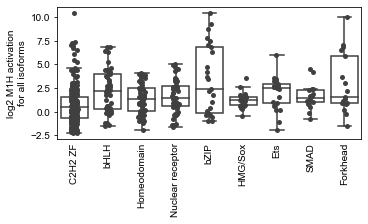

In [6]:
# m1h for all isoforms

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=m1h, x='DBD', y='mean', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=m1h, x='DBD', y='mean', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('log2 M1H activation\nfor all isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
for dbd in dbd_to_plot:
    print(dbd, stats.mannwhitneyu(m1h.loc[(m1h['DBD'] == 'C2H2 ZF') & m1h['mean'].notnull(), 'mean'].values,
                                  m1h.loc[(m1h['DBD'] == dbd) & m1h['mean'].notnull(), 'mean'].values)[1] * 8)

plt.savefig('../figures/M1H-all_isoforms_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

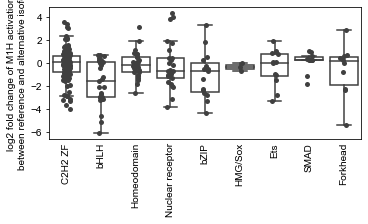

In [7]:
df['m1h_change'] = df['m1h_alt'] - df['m1h_ref']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='m1h_change', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='m1h_change', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)
plt.savefig('../figures/M1H-change_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

C2H2 ZF 8.0
bHLH 0.11223030731040626
Homeodomain 4.292340055120987
Nuclear receptor 0.05652505227331872
bZIP 0.1256377966996747
HMG/Sox 1.4949612838065314
Ets 4.14145827039297
SMAD 3.7550564754911013
Forkhead 3.2739197330504783


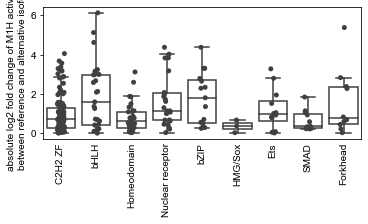

In [7]:
# absolute difference
df['m1h_abs_change'] = (df['m1h_alt'] - df['m1h_ref']).abs()
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='m1h_abs_change', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='m1h_abs_change', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('absolute log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
for dbd in dbd_to_plot:
    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/M1H-absolute-change_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

In [9]:
from data_loading import DIMERIZING_TF_FAMILIES
df['is_dimerizing_tf'] = df['DBD'].isin(DIMERIZING_TF_FAMILIES)

In [12]:
from statannotations.Annotator import Annotator

0.009040812675571743
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: P = 0.009


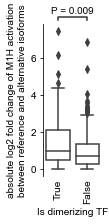

In [19]:
# absolute difference
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.4, h=3)
sns.boxplot(data=df, x='is_dimerizing_tf', y='m1h_abs_change', order=[True, False], ax=ax, boxprops={'facecolor': 'w'})#, fliersize=0)
#sns.stripplot(data=df, x='is_dimerizing_tf', y='m1h_abs_change', order=[True, False], ax=ax, color='.25')
ax.set_xlabel('Is dimerizing TF')
ax.set_ylabel('absolute log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)
for loc in ['bottom', 'right', 'top']:
    ax.spines[loc].set_visible(False)

# p-value
pval = stats.mannwhitneyu(df.loc[df['is_dimerizing_tf'] & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
                          df.loc[~df['is_dimerizing_tf'] & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1]
print(pval)
annotator = Annotator(ax=ax, pairs=[(True, False)], data=df, x='is_dimerizing_tf', y='m1h_abs_change', order=[True, False],)
annotator.configure(loc='outside')
# TODO: set this programmatically
annotator.annotate_custom_annotations(['P = {:.3f}'.format(pval)])
plt.savefig('../figures/M1H-absolute-change_by-dimerizing-TF-family_boxplot.pdf',
            bbox_inches='tight')

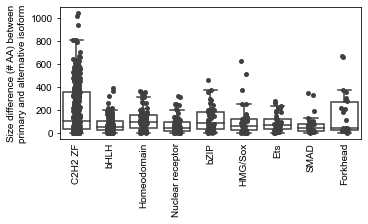

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='n_aa_diff', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='n_aa_diff', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('Size difference (# AA) between\nprimary and alternative isoform')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
#for dbd in dbd_to_plot:
#    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
#                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/n-AA-diff_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

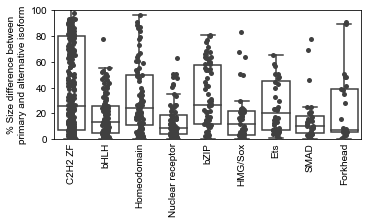

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='pct_aa_diff', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='pct_aa_diff', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('% Size difference between\nprimary and alternative isoform')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.set_ylim(0, 100)

# p-values
#for dbd in dbd_to_plot:
#    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
#                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/pct-AA-diff_by-TF-family_boxplot.pdf',
            bbox_inches='tight')